In [1]:
import logging
logger = logging.getLogger(__name__)

import sys
import json
import numpy as np
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from tools.utils import MpcDataset, MpcDatasetHDF5
from tools.models import HVACModeMLP

# Logging setup
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s | %(filename)s:%(funcName)s | %(levelname)s | %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    stream=sys.stdout
)


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cpu


In [ ]:
# Load data
data_path = Path().cwd() / "data" / "220days_2025-02-10_2025-09-18" / "dataset"

train_dataloader = DataLoader(
    MpcDatasetHDF5(
        hdf5_file=data_path / "train.h5", 
        cache_in_memory=True, 
        verbose=True), 
    batch_size=512, 
    shuffle=True
)

val_dataloader = DataLoader(MpcDatasetHDF5(hdf5_file=data_path / "val.h5", cache_in_memory=True, verbose=True), batch_size=512, shuffle=False)
test_dataloader = DataLoader(MpcDatasetHDF5(hdf5_file=data_path / "test.h5", verbose=True), batch_size=512, shuffle=False)


HDF5 Dataset Info for train.h5:
  Input chunks: (100, 48, 16) (chunk = 0.29 MB)
  Output chunks: (100, 3) (chunk = 0.00 MB)

  Loading entire dataset into memory from /home/ahojrup/GitLab/mpc_ahu_neural_network/data/7days_2025-09-14_2025-09-21/dataset/train.h5...
    Expected memory usage:
      Inputs:  (19850, 48, 16) × float32 = 0.057 GB
      Outputs: (19850, 3) × float32 = 0.000 GB
      Total:   0.057 GB

  Actual memory allocated: 0.060 GB
  Loaded 19,850 samples into memory
  Effective compression ratio: 0.96x



HDF5 Dataset Info for val.h5:
  Input chunks: (100, 48, 16) (chunk = 0.29 MB)
  Output chunks: (100, 3) (chunk = 0.00 MB)

  Loading entire dataset into memory from /home/ahojrup/GitLab/mpc_ahu_neural_network/data/7days_2025-09-14_2025-09-21/dataset/val.h5...
    Expected memory usage:
      Inputs:  (4253, 48, 16) × float32 = 0.012 GB
      Outputs: (4253, 3) × float32 = 0.000 GB
      Total:   0.012 GB

  Actual memory allocated: 0.012 GB
  Loaded 4,253 samples into

In [3]:
# Load metadata and initialize model
dataset_metadata = json.loads((data_path / "stats" / "metadata.json").read_text())
model = HVACModeMLP(window_size=dataset_metadata["window"], feature_dim=dataset_metadata["feature_dim"], n_classes=dataset_metadata["num_classes"])
model.to(device=DEVICE)



# Setup training components
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
num_epochs = 5

# Track metrics
train_losses = []
val_losses = []
val_accuracies = []
best_val_accuracy = 0.0

# Training loop
for epoch in range(num_epochs):
    # ============= Training Phase =============
    model.train()
    train_loss = 0.0
    train_batches = 0
    
    for batch_x, batch_y in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        # Move data to device
        batch_x: torch.Tensor = batch_x.to(DEVICE)
        batch_y: torch.Tensor = batch_y.to(DEVICE)
        
        # Handle target format based on your dataset
        # If batch_y is class indices (shape: [batch_size])
        if batch_y.dim() == 1:
            target = batch_y.long()
        # If batch_y is one-hot (shape: [batch_size, num_classes])
        else:
            target = batch_y.argmax(dim=1).long()
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = loss_fn(outputs, target)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_batches += 1
    
    avg_train_loss = train_loss / train_batches
    train_losses.append(avg_train_loss)
    
    # ============= Validation Phase =============
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch_x, batch_y in tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            # Move data to device
            batch_x = batch_x.to(DEVICE)
            batch_y = batch_y.to(DEVICE)
            
            # Handle target format
            if batch_y.dim() == 1:
                target = batch_y.long()
            else:
                target = batch_y.argmax(dim=1).long()
            
            # Forward pass
            outputs = model(batch_x)
            loss = loss_fn(outputs, target)
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += target.size(0)
            val_correct += (predicted == target).sum().item()
            
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    
    # Print epoch results
    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.2f}%")
    
    # Save best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_accuracy': val_accuracy,
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
        }, data_path.resolve() / 'best_hvac_model.pt')
        print(f"  → Saved new best model (accuracy: {val_accuracy:.2f}%)")

print(f"\nTraining complete! Best validation accuracy: {best_val_accuracy:.2f}%")

Epoch 1/5 - Validation: 100%|██████████| 9/9 [00:00<00:00, 150.69it/s]


Epoch [1/5] - Train Loss: 0.2837, Val Loss: 1.8506, Val Accuracy: 83.52%
  → Saved new best model (accuracy: 83.52%)


Epoch 2/5 - Validation: 100%|██████████| 9/9 [00:00<00:00, 94.27it/s]


Epoch [2/5] - Train Loss: 0.1168, Val Loss: 1.5919, Val Accuracy: 83.52%


Epoch 3/5 - Validation: 100%|██████████| 9/9 [00:00<00:00, 123.63it/s]


Epoch [3/5] - Train Loss: 0.1068, Val Loss: 1.3653, Val Accuracy: 83.52%


Epoch 4/5 - Validation: 100%|██████████| 9/9 [00:00<00:00, 144.40it/s]


Epoch [4/5] - Train Loss: 0.0971, Val Loss: 1.3837, Val Accuracy: 83.52%


Epoch 5/5 - Validation: 100%|██████████| 9/9 [00:00<00:00, 139.24it/s]

Epoch [5/5] - Train Loss: 0.0914, Val Loss: 1.2208, Val Accuracy: 83.52%

Training complete! Best validation accuracy: 83.52%


In [4]:
# ============= Test Phase =============
print("\nEvaluating on test set...")

# Load metadata and initialize model
dataset_metadata = json.loads((data_path / "stats" / "metadata.json").read_text())
model = HVACModeMLP(window_size=dataset_metadata["window"], feature_dim=dataset_metadata["feature_dim"], n_classes=dataset_metadata["num_classes"])
model.to(device=DEVICE)

# Load best model
checkpoint = torch.load(data_path.resolve() / 'best_hvac_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()
test_correct = 0
test_total = 0
class_correct = [0] * dataset_metadata["num_classes"]
class_total = [0] * dataset_metadata["num_classes"]

all_targets = []
all_preds = []

with torch.no_grad():
    for batch_x, batch_y in tqdm(test_dataloader, desc="Testing"):
        batch_x = batch_x.to(DEVICE)
        batch_y = batch_y.to(DEVICE)
        
        if batch_y.dim() == 1:
            target = batch_y.long()
        else:
            target = batch_y.argmax(dim=1).long()
        
        outputs = model(batch_x)
        _, predicted = torch.max(outputs, 1)
        
        test_total += target.size(0)
        test_correct += (predicted == target).sum().item()
        
        # Per-class accuracy
        for i in range(target.size(0)):
            label = target[i].item()
            class_total[label] += 1
            if predicted[i] == target[i]:
                class_correct[label] += 1
        
        # For confusion matrix
        all_targets.extend(target.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Print final results
test_accuracy = 100 * test_correct / test_total
print(f"\nTest Accuracy: {test_accuracy:.2f}%")
print("\nPer-class accuracies:")
for i in range(dataset_metadata["num_classes"]):
    if class_total[i] > 0:
        acc = 100 * class_correct[i] / class_total[i]
        print(f"  Mode {i}: {acc:.2f}% ({class_correct[i]}/{class_total[i]})")


Evaluating on test set...


Testing:   0%|          | 0/9 [00:00<?, ?it/s]

Testing: 100%|██████████| 9/9 [00:02<00:00,  3.14it/s]


Test Accuracy: 100.00%

Per-class accuracies:
  Mode 1: 100.00% (4253/4253)


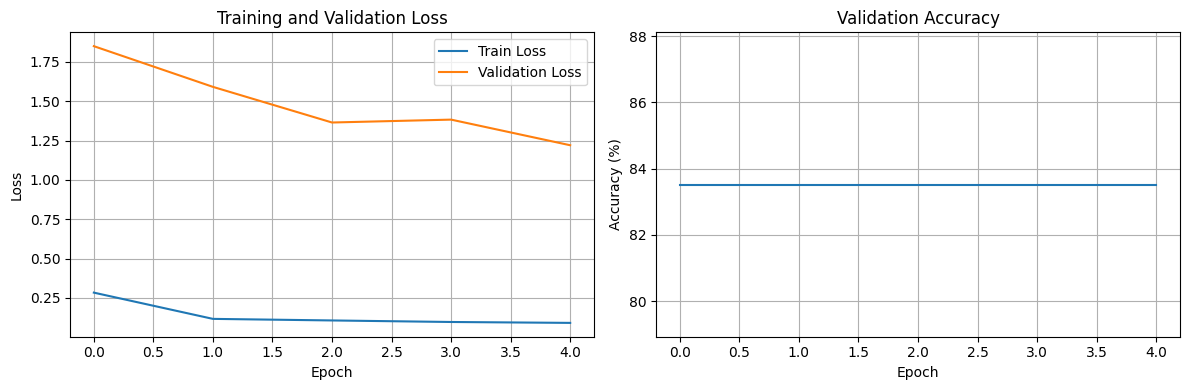

In [5]:
# Optional: Plot training curves
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.grid(True)

plt.tight_layout()
plt.savefig(data_path.resolve() / 'training_curves.png')
plt.show()

/home/ahojrup/miniforge3/envs/pytorch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


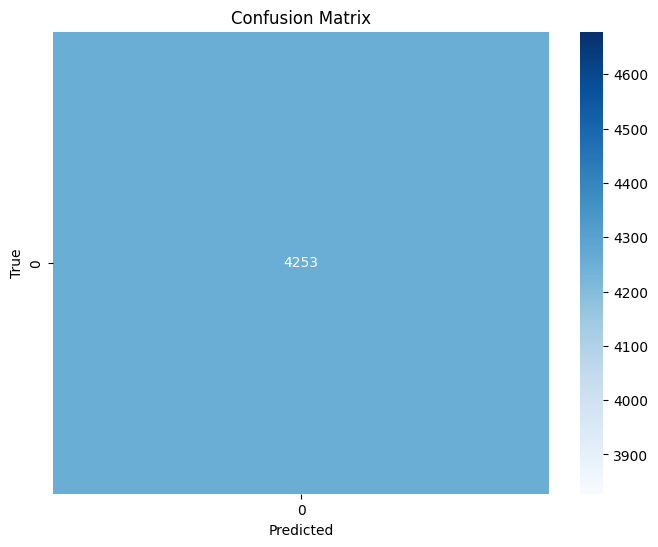

In [6]:
# Compute confusion matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Train a simple decision tree to check feature importance
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X_train_flattened, y_train)